# Reverse Ecology and Metatranscriptomics of Uncultivated Freshwater Actinobacteria

## Figure S5a/b: Completeness as a Function of Sample Size

### Overview
This figure will contain one or more plots showing how a tribe/clade's completeness varies as a function of the number of genomes sampled. The workflow contains the following steps:

For completeness:

1. Download reference genomes.
2. Extract concatenated marker gene sequences using [Phylosift](https://phylosift.wordpress.com/) or [CheckM](http://ecogenomics.github.io/CheckM/).
3. Assemble results into a matrix.
4. Compute min/max/mean for all clades and sample sizes.
5. Plot the results

### Step 1: Downloading Reference Genomes

The reference genomes used in this study are available through IMG, Genbank, and a personal website, as described in Table 1. The genome sequences need to be downloaded in FASTA nucleotide format and placed in `data/refGenomes/fna`. One file per genome, of the form `genome.fna`.

### Step 2: Extract Marker Genes using CheckM

Phylosift was used to extract marker genes in a previous code cell, the analysis will not be repeated here. CheckM will be run using Actinobacterial-specific marker genes.

In [ ]:
%reset
# Import packages
import os
import subprocess

# Define folders
genomeDir = '../data/refGenomes/fna'
scratchDir = '../data/scratch'
checkMDir = scratchDir+'/checkm'

# Check that checkM dir exists to store output
if not os.path.exists(checkMDir):
    os.makedirs(checkMDir)
    
# Run checkM
outFile = open(checkMDir+'/out.txt', 'w')
subprocess.call(['checkM', 'taxonomy_wf', 'phylum', 'Actinobacteria', genomeDir,
                 checkMDir], stdout=outFile)
outFile.close()

### Step 3: Aggregate Marker Gene Data

This chunk of code parses the output of CheckM. For each set of marker genes, the code generates a table in which rows are genomes, and columns indicate the presence/absence of a particular marker gene.

In [ ]:
%reset
# Import packages
import os
import pandas as pd
import re

# Define folders
genomeDir = '../data/refGenomes/fna'
scratchDir = '../data/scratch'
checkMDir = scratchDir+'/checkm'
resultsDir = '../figures'
samplingDir = resultsDir+'/figS-sampling'
checkmGeneSet = checkMDir+'/Actinobacteria.ms'

# Check that samplingDir exists, as analyses will go there
if not os.path.exists(samplingDir):
    os.makedirs(samplingDir)

# Retrieve the list of genomes to process
genomeList = []
for item in os.listdir(genomeDir):
    if item.endswith('.fna'):
        genomeList.append(item)
        
genomeList = [genome.replace('.fna', '') for genome in genomeList]

### CheckM

# Identify the marker genes used by CheckM
with open(checkmGeneSet) as inFile:
    statFile = inFile.readlines()
splitLine = statFile[1].split("\t")
markerGeneList = re.findall('PF\d+\.\d+', splitLine[5])
markerGeneList.extend(re.findall('TIGR\d+', splitLine[5]))

# Initialize an empty dataframe
checkmDF = pd.DataFrame(index=markerGeneList)
    
# Read in stat table
with open(checkMDir+'/storage/marker_gene_stats.tsv') as inFile:
    statFile = inFile.readlines()

# For each line of the array, split it along the '\t' character
for myLine in statFile:
    splitLine = myLine.split("\t")

# Add the first element of the array as a column to the dataframe
    checkmDF[splitLine[0]] = 0

# Regex to find all marker genes in the second line
    markerGeneList = re.findall('PF\d+\.\d+', splitLine[1])
    markerGeneList.extend(re.findall('TIGR\d+', splitLine[1]))

# For each element in the set, add a '1' at the appropriate location
    for markerGene in markerGeneList:
        checkmDF.loc[markerGene, splitLine[0]] = 1

# Replace all the NaN values with zeros
    checkmDF.fillna(0, inplace=True)

# Write to file
pd.DataFrame.to_csv(checkmDF, samplingDir+'/checkm.csv')

### Step 4: Compute Mean/Min/Max Completeness for each {Clade/Tribe, Sample Size} Pairing

This section of code computes the data underlying the sampling completeness plots. For a given clade or tribe, this chunk of code:

1. Identifies the number of genomes belonging to the group.
2. Computes all possible permutations of genomes for a given sample size.
3. For each permutation, computes the completeness.
4. Records the mean/min/max completeness for each sample.

In [ ]:
%reset
# Import packages
import random
import pandas as pd

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/figS-sampling'
phylosiftResults = samplingDir+'/phylosift.csv'
checkmResults = samplingDir+'/checkm.csv'

# Define parameters
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Establish a dataframe giving the presence/absence of each marker gene in the genome
phylosiftRawDF = pd.read_csv(phylosiftResults, index_col=0, sep=',')
checkmRawDF = pd.read_csv(checkmResults, index_col=0, sep=',')

# Create dictionaries giving the samples which belong to each clade/tribe
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))  
        
        # Create an empty dataframe to store the results, indexed by sample size
        checkmDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                              columns=['Min', 'Mean', 'Max', 'St Dev'])
        
        phylosiftDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                                columns=['Min', 'Mean', 'Max', 'St Dev'])
                
        # For each sample size (can use either dataframe, indices are the same)
        for sampleSize in checkmDF.index:

            print "Processing sample size %d of %d" % (sampleSize, len(checkmDF.index))  
        
            # Create a list of all 100 random samples, and a dataframe to store the completeness
            sampleList = [tuple([random.choice(curDict[group]) for _ in range(sampleSize)]) for _ in range(sampleN)]

            # It is possible to have identical samples, so we can't index on
            # the sample. Instead, index on sample number
            sampleDF = pd.DataFrame(0.0, index=range(len(sampleList)), 
                                    columns=['Phylosift', 'CheckM'])
            
            sampleIndex = 0
            for sample in sampleList:
                # Create temporary dataframes containing only the appropriate columns
                phylosiftTempDF = phylosiftRawDF[list(sample)]
                checkmTempDF = checkmRawDF[list(sample)]

                # Estimate the percent completeness. First, merge the columns, 
                # counting the number of marker genes across the genomes.
                mergePhylosiftTempDF = phylosiftTempDF.sum(axis=1)
                mergeCheckmTempDF = checkmTempDF.sum(axis=1)
                
                # Then, count the number of non-zero occurences and normalize by
                # the total number of marker genes
                phylosiftEst = sum(mergePhylosiftTempDF !=0) / float(len(mergePhylosiftTempDF))
                checkmEst = sum(mergeCheckmTempDF !=0) / float(len(mergeCheckmTempDF))
                
                # And place the result in the sampleDF for the appropriate sample
                sampleDF.loc[sampleIndex, 'Phylosift'] = phylosiftEst
                sampleDF.loc[sampleIndex, 'CheckM'] = checkmEst
                sampleIndex = sampleIndex + 1
            
            # Compute the min, max, and mean estimated completeness
            # Store under the appropriate sample size            
            phylosiftDF.loc[sampleSize, 'Min'] = sampleDF['Phylosift'].min()
            phylosiftDF.loc[sampleSize, 'Mean'] = sampleDF['Phylosift'].mean()
            phylosiftDF.loc[sampleSize, 'Max'] = sampleDF['Phylosift'].max()
            phylosiftDF.loc[sampleSize, 'St Dev'] = sampleDF['Phylosift'].std()
            
            checkmDF.loc[sampleSize, 'Min'] = sampleDF['CheckM'].min()
            checkmDF.loc[sampleSize, 'Mean'] = sampleDF['CheckM'].mean()
            checkmDF.loc[sampleSize, 'Max'] = sampleDF['CheckM'].max()
            checkmDF.loc[sampleSize, 'St Dev'] = sampleDF['CheckM'].std()
            
        # Write the results to file
        pd.DataFrame.to_csv(phylosiftDF, samplingDir+'/'+group+'-phylosift.csv')
        pd.DataFrame.to_csv(checkmDF, samplingDir+'/'+group+'-checkm.csv')

### Step 5: Plot Mean Completeness for Tribe/Clade as a Function of Sample Size

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Processing taxonomic level 1 of 2
Processing group 1 of 3
Processing group 2 of 3
Processing group 3 of 3
Processing taxonomic level 2 of 2
Processing group 1 of 7
Processing group 2 of 7
Processing group 3 of 7
Processing group 4 of 7
Processing group 5 of 7
Processing group 6 of 7
Processing group 7 of 7


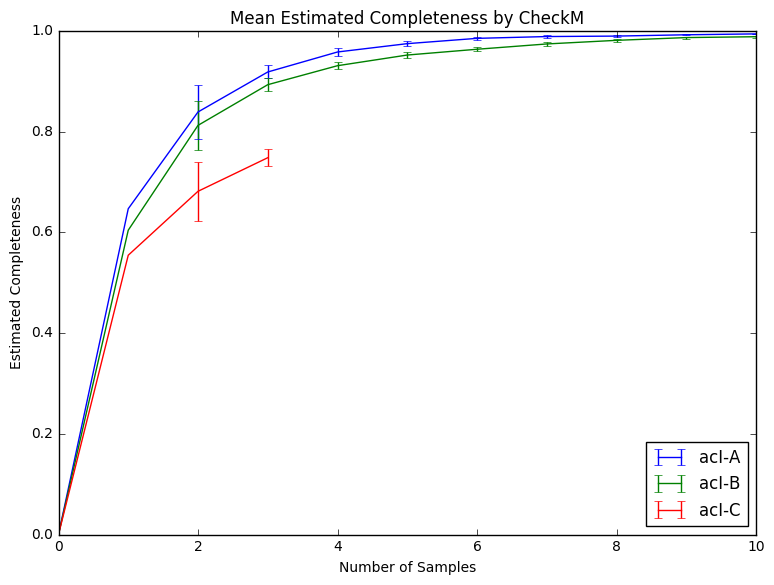

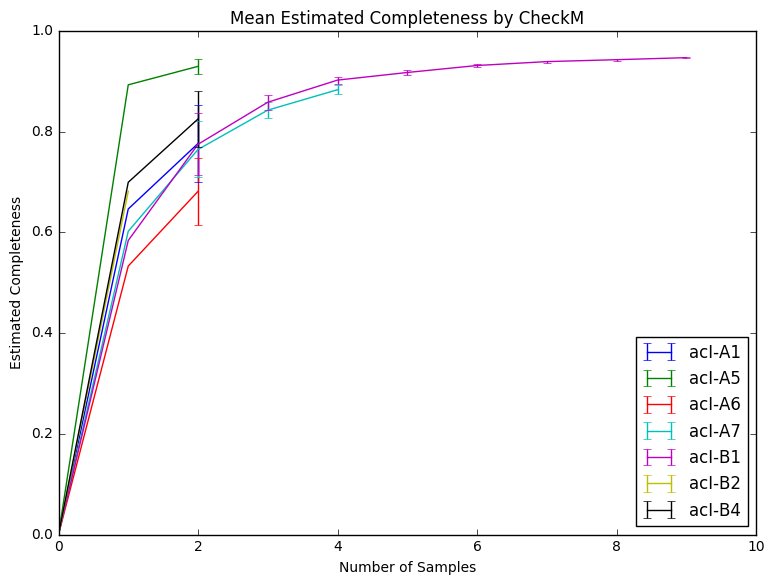

In [2]:
%reset
# Import packages
import inspect
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
%matplotlib inline

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/figS-sampling'

# Define parameters
confidence = 0.95
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Create dictionaries giving the samples which belong to each clade/tribe
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    # Find the max sample size, to use for DF indexing
    sampleLenList = []
    for group in curDict.keys():
        sampleLenList.append(len(curDict[group]))

    # Create an empty dataframe to store the results, indexed by sample size
    checkmDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    checkmCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
        
    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))
        
        # Read in the dataframe of estimated completeness and add 'Mean' to the
        # results dataframe
        checkmGroupDF = pd.read_csv(samplingDir+'/'+group+'-checkm.csv', index_col=0, sep=',')
        checkmDF[group] = checkmGroupDF['Mean']

        # Compute student's t-scores to use with calculation of confidence interval.
        # Shorten to the approptiate length: only retain t-scores for sample sizes
        # in the group
        studentT = scipy.stats.t.ppf((1+confidence) / 2, checkmDF.index-1)
        studentT = studentT[0:len(curDict[group])]

        # Compute the confidence interval
        checkmCIDF[group] = studentT* checkmGroupDF['St Dev'] / math.sqrt(sampleN)
        
    # Sort dataframe columns alphabetically
    checkmDF = checkmDF.sort_index(axis=1)
        
    # Add zero-row and resort on the index
    appendDF = pd.DataFrame(0, index = [0], columns=curDict.keys())

    checkmDF = checkmDF.append(appendDF)
    checkmDF = checkmDF.sort_index(axis=0)
  
    checkmCIDF = checkmCIDF.append(appendDF)
    checkmCIDF = checkmCIDF.sort_index(axis=0)
    
    # Plot the results
    plt.figure(figsize=(9, 6.5))
    plt.title('Mean Estimated Completeness by CheckM')
    for column in checkmDF.columns:
        plt.errorbar(checkmDF.index, checkmDF[column], yerr=checkmCIDF[column],linewidth=1)
    plt.xlim(0, 10)
    plt.ylim(0, 1)
    plt.xlabel('Number of Samples')
    plt.ylabel('Estimated Completeness')
    plt.legend(checkmDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'completeness-'+str(taxonDictList.index(curDict)+1)+'.svg')